# Pose Detection

---
### CHANGE CHANGE
Welcome to Amazon [SageMaker Built-In Algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use Sagemaker Built-In Algorithms to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart). 

In this demo notebook, we demonstrate how to use the SageMaker Python SDK for Image Classification. Image Classification refers to classifying an image to one of the class labels of the training dataset.  We demonstrate two use cases of Image Classification models:

* How to use a model pre-trained on ImageNet dataset to classify an image. [ImageNetLabels](https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt).
* How to fine-tune a pre-trained model to a custom dataset, and then run inference on the fine-tuned model.

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

---

1. [Set Up](#1.-Set-Up)
2. [Select a pre-trained model](#2.-Select-a-pre-trained-model)
3. [Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model)
    * [Retrieve Artifacts & Deploy an Endpoint](#3.1.-Retrieve-Artifacts-&-Deploy-an-Endpoint)
    * [Download example images for inference](#3.2.-Download-example-images-for-inference)
    * [Query endpoint and parse response](#3.3.-Query-endpoint-and-parse-response)
    * [Clean up the endpoint](#3.4.-Clean-up-the-endpoint)
4. [Fine-tune the pre-trained model on a custom dataset](#4.-Fine-tune-the-pre-trained-model-on-a-custome-dataset)
    * [Retrieve Training artifacts](#4.1.-Retrieve-Training-artifacts)
    * [Set Training parameters](#4.2.-Set-Training-parameters)
    * [Train with Automatic Model Tuning (HPO)](#AMT)
    * [Start Training](#4.4.-Start-Training)
    * [Deploy & run Inference on the fine-tuned model](#4.5.-Deploy-&-run-Inference-on-the-fine-tuned-model)
    * [Incrementally train the fine-tuned model](#4.6.-Incrementally-train-the-fine-tuned-model)

## 1. Set Up
***
Before executing the notebook, there are some initial steps required for setup. This notebook requires latest version of sagemaker and ipywidgets.
***

In [2]:
!pip install --upgrade pip --quiet

We will use OpenCV so we need to install it first

In [3]:
!apt-get -q update


Get:1 http://security.debian.org/debian-security buster/updates InRelease [34.8 kB]
Hit:2 http://deb.debian.org/debian buster InRelease
Get:3 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Fetched 91.5 kB in 0s (308 kB/s)
Reading package lists...


In [4]:
!apt-get -q install ffmpeg libsm6 libxext6  -y

Reading package lists...
Building dependency tree...
Reading state information...
libsm6 is already the newest version (2:1.2.3-1).
libxext6 is already the newest version (2:1.3.3-1+b2).
ffmpeg is already the newest version (7:4.1.9-0+deb10u1).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.


In [5]:
!pip install opencv-python

In [6]:
! pip install mxnet

In [7]:
!pip install --upgrade gluoncv

---

To train and host on Amazon Sagemaker, we need to setup and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook instance as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3. 

---

In [8]:
import sagemaker, boto3, json
import numpy as np
import cv2
import mxnet as mx
import math
from sagemaker.session import Session
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

Some Useful functions

In [9]:
class Joint():
    def __init__(self, name, x,y,conf):
        self.name = name
        self.coords = (float(x),float(y))
        self.conf = float(conf)

In [10]:
class Bodypart():
    def __init__(self, name, jointA, jointB):
        self.jointA = jointA
        self.jointB = jointB
        self.name = name
    def get_metrics(self):
        self.vec = [b - a for a,b in zip(self.jointA.coords, self.jointB.coords)]
        self.length = float(math.hypot(self.vec[1], self.vec[0]))
        if self.vec[0] != 0:
            self.orient = float(math.degrees(math.atan(self.vec[1]/self.vec[0])))
        else:
            self.orient = 90.0
        self.conf = float(self.jointA.conf * self.jointA.conf)
        

## 2. Select a pre-trained model
***
You can continue with the default model, or can choose a different model from the dropdown generated upon running the next cell. A complete list of SageMaker pre-trained models can also be accessed at [Sagemaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#).
***

In [11]:
frame = mpimg.imread('post-test-warrior1.jpg')

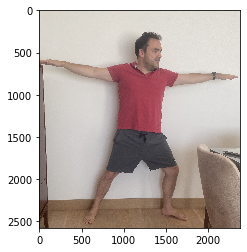

In [12]:
%matplotlib inline
plt.imshow(frame)
plt.show()

***
Select a different Sagemaker pre-trained model. Here, we download the model_manifest file from the Built-In Algorithms s3 bucket, filter-out all the Image Classification models and select a model for inference.
***

In [13]:
from gluoncv import model_zoo, data, utils
from gluoncv.data.transforms.pose import detector_to_simple_pose, heatmap_to_coord

### Load a pretrained model

You load two pre-trained models, one to detect people (yolo3_mobilenet1.0_coco) in the frame and one to detect the pose (simple_pose_resnet18_v1b) for each person detected. To load the pre-trained models, enter the following code in a new code cell: 

In [14]:
people_detector = model_zoo.get_model('yolo3_mobilenet1.0_coco', pretrained=True)
pose_detector = model_zoo.get_model('simple_pose_resnet18_v1b', pretrained=True)

Because the yolo_mobilenet1.0_coco pre-trained model is trained to detect many types of objects in addition to people, the code below narrows down the detection criteria to just people so that the model runs faster.

In [15]:
people_detector.reset_class(["person"], reuse_weights=['person'])

In [16]:
type(people_detector)

gluoncv.model_zoo.yolo.yolo3.YOLOV3

### Pre-process an image for detector, and make inference

The following code shows how to use the people detector to detect people in the frame. The outputs of the people detector are the class_IDs (just “person” in this use case because we’ve limited the model’s search scope), the confidence scores, and a bounding box around each person detected in the frame. 

This function returns two results. The first is a NDArray with shape (batch_size, RGB_channels, height, width). It can be fed into the model directly. The second one contains the images in numpy format to easy to be plotted. Since we only loaded a single image, the first dimension of x is 1.

In [ ]:
img = mx.nd.array(frame)
x, img = data.transforms.presets.ssd.transform_test(img, short=256)


Let's detect people

In [ ]:
class_IDs, scores, bounding_boxs = people_detector(x)

### Process tensor from detector to keypoint network

For a Simple Pose network, it expects the input has the size 256x192, and the human is centered. We crop the bounding boxed area for each human, and resize it to 256x192, then finally normalize it.

In order to make sure the bounding box has included the entire person, we usually slightly upscale the box size.



In [ ]:
pose_input, upscale_bbox = detector_to_simple_pose(img, class_IDs, scores, bounding_boxs)

### Predict with a Simple Pose network

Now we can make prediction.

A Simple Pose network predicts the heatmap for each joint (i.e. keypoint). After the inference we search for the highest value in the heatmap and map it to the coordinates on the original image.

In [ ]:
predicted_heatmap = pose_detector(pose_input)
pred_coords, confidence = heatmap_to_coord(predicted_heatmap, upscale_bbox)

### Pre-process an image for detector, and make inference¶
Using SageMaker, we can perform inference on the pre-trained model, even without fine-tuning it first on a custom dataset. For this example, that means on an input image, predicting the class label from one of the 1000 classes of the ImageNet dataset. 

**Bounding Box**: [x,y, width, height]


In [ ]:
ax = utils.viz.plot_keypoints(img, pred_coords, confidence,
                              class_IDs, bounding_boxs,scores, box_thresh=0.2, keypoint_thresh=0.2)
plt.show(ax)

In [ ]:
pred_coords_clean = pred_coords.asnumpy()
confidence_clean = confidence.asnumpy()
bounding_boxs_clean = bounding_boxs.asnumpy()
scores_clean = scores.asnumpy()

#### **BodyParts Result JSON format:**

We work on this one

In [ ]:
keys_Joints = ['Nose', 'Right Eye', 'Left Eye', 'Right Ear','Left Ear','Right Shoulder',
         'Left Shoulder','Right Elbow','Left Elbow','Right Wrist','Left Wrist','Right Hip',
         'Left Hip','Right Knee','Left Knee','Right Ankle','Left Ankle']

In [ ]:
allJoints = [{name:Joint(name,coord[0],coord[1],conf[0]) for name,coord,conf in zip(keys_Joints, coord_per_person, conf_per_person)} 
                  for coord_per_person, conf_per_person in zip(pred_coords_clean,confidence_clean)]

Definition of Body

In [ ]:
BodyForm = {
    'Right Lower Arm': ['Right Shoulder','Right Elbow'],
    'Left Lower Arm': ['Left Shoulder','Left Elbow'],
    'Right Upper Arm': ['Right Elbow', 'Right Wrist'],
    'Left Upper Arm': ['Left Elbow', 'Left Wrist'],
    'Right Thigh': ['Right Hip', 'Right Knee'],
    'Left Thigh': ['Left Hip', 'Left Knee'],
    'Hips': ['Left Hip', 'Right Hip'],
    'Shoulders': ['Left Shoulder', 'Right Shoulder'],
}

Creating the body class

In [ ]:
allBodyParts = [{bodypart_name:Bodypart(bodypart_name, joint[joint_names[0]], joint[joint_names[1]]) 
                 for bodypart_name, joint_names in BodyForm.items()} for joint in allJoints]

In [ ]:
allBodyparts = []
for joint in allJoints:
    iter_body = {}
    for bodypart_name, joint_names in BodyForm.items():
        body = Bodypart(bodypart_name, joint[joint_names[0]], joint[joint_names[1]])
        body.get_metrics()
        iter_body.update({bodypart_name:body})
    allBodyparts.append(iter_body)

In [ ]:
allBodyparts

#### **Global Picture Result JSON format:**

In [ ]:
keys_BoundingBox = ["X0","Y0", "Width", "Height"]

In [ ]:
resBoundingBox = [{"BoundingBox":{"Coords":{key:float(value) for key,value in zip(keys_BoundingBox,Boundingbox_per_person[0])}
                       ,"Confidence":float(conf_per_person[0][0])}}
                  for Boundingbox_per_person, conf_per_person in zip(bounding_boxs_clean,scores_clean)]

In [ ]:
paramsJoints = []
for allJoints_pp in allJoints:
    paramsJoints_pp = {}
    for joint_name in keys_Joints:
        joint = allJoints_pp[joint_name]
        paramsJoints_pp.update({joint_name:{"Coords":joint.coords, "Conf":joint.conf}})
    paramsJoints.append(paramsJoints_pp)

In [ ]:
paramsBodyparts = []
for allBodyparts_pp in allBodyparts:
    paramsBodyparts_pp = {}
    for bodypart_name in BodyForm:
        body = allBodyparts_pp[bodypart_name]
        paramsBodyparts_pp.update({bodypart_name:{"Angle":body.orient, "Conf":body.conf}})
    paramsBodyparts.append(paramsBodyparts_pp)

In [ ]:
paramsJoints

Lt's combine all of these

In [ ]:
res = [{"PersonID":person,**Bbox, "Joints":Joint, "Bodyparts":Body} for person,(Bbox,Joint, Body)
       in enumerate(zip(resBoundingBox, paramsJoints, paramsBodyparts)) ]

In [ ]:
isinstance((res[0]['BoundingBox']['Coords']['X0']), np.floating)

In [ ]:
res

In [ ]:
json_res = json.dumps(res)

In [ ]:
json_res

In [57]:
!jupyter nbconvert --to script 'yogi-sagemaker-cv.ipynb'

Traceback (most recent call last):
  File "/opt/conda/bin/jupyter-nbconvert", line 7, in <module>
    from nbconvert.nbconvertapp import main
  File "/opt/conda/lib/python3.7/site-packages/nbconvert/__init__.py", line 4, in <module>
    from .exporters import *
  File "/opt/conda/lib/python3.7/site-packages/nbconvert/exporters/__init__.py", line 3, in <module>
    from .html import HTMLExporter
  File "/opt/conda/lib/python3.7/site-packages/nbconvert/exporters/html.py", line 12, in <module>
    from jinja2 import contextfilter
ImportError: cannot import name 'contextfilter' from 'jinja2' (/opt/conda/lib/python3.7/site-packages/jinja2/__init__.py)


## Set up hosting for the model
### Export the model from mxnet
***
In order to set up hosting, we have to import the model from training to hosting. We will begin by exporting the model from MXNet and saving it down. Analogous to the [`TensorFlow example`](https://github.com/aws/amazon-sagemaker-examples/blob/1c5da8941bc933b176b56a93157073d5645d8cdf/advanced_functionality/tensorflow_iris_byom/tensorflow_BYOM_iris.ipynb), some structure needs to be followed. The exported model has to be converted into a form that is readable by` sagemaker.mxnet.model.MXNetModel`. The following code describes exporting the model in a form that does the same:
***

In [58]:
import os
import json
import tarfile

os.mkdir("model")

model.save_checkpoint("model/model", 0000)
with open("model/model-shapes.json", "w") as shapes:
    json.dump([{"shape": model.data_shapes[0][1], "name": "data"}], shapes)

def flatten(tarinfo):
    tarinfo.name = os.path.basename(tarinfo.name)
    return tarinfo


tar = tarfile.open("model.tar.gz", "w:gz")
tar.add("model", filter=flatten)
tar.close()

NameError: name 'model' is not defined

### 3.2. Download example images for inference
***
We download example images from the Built-In Algorithms S3 bucket.
***

In [ ]:
s3_bucket = f"jumpstart-cache-prod-{aws_region}"
key_prefix = "inference-notebook-assets"


def download_from_s3(images):
    for filename, image_key in images.items():
        boto3.client("s3").download_file(s3_bucket, f"{key_prefix}/{image_key}", filename)


images = {"img1.jpg": "cat.jpg", "img2.jpg": "dog.jpg"}
download_from_s3(images)

### 3.3. Query endpoint and parse response
***
Input to the endpoint is a single image in binary format. Response from the endpoint is a dictionary containing the top-1 predicted class label, and a list of class probabilities.
***

In [ ]:
from IPython.core.display import HTML


def predict_top_k_labels(probabilities, labels, k):
    topk_prediction_ids = sorted(
        range(len(probabilities)), key=lambda index: probabilities[index], reverse=True
    )[:k]
    topk_class_labels = ", ".join([labels[id] for id in topk_prediction_ids])
    return topk_class_labels


for image_filename in images.keys():
    with open(image_filename, "rb") as file:
        img = file.read()
    query_response = base_model_predictor.predict(
        img, {"ContentType": "application/x-image", "Accept": "application/json;verbose"}
    )
    model_predictions = json.loads(query_response)
    labels, probabilities = model_predictions["labels"], model_predictions["probabilities"]
    top5_class_labels = predict_top_k_labels(probabilities, labels, 5)
    display(
        HTML(
            f'<img src={image_filename} alt={image_filename} align="left" style="width: 250px;"/>'
            f"<figcaption>Top-5 predictions: {top5_class_labels} </figcaption>"
        )
    )

### 3.4. Clean up the endpoint

In [ ]:
# Delete the SageMaker endpoint and the attached resources
base_model_predictor.delete_model()
base_model_predictor.delete_endpoint()

## 4. Fine-tune the pre-trained model on a custom dataset
***
Previously, we saw how to run inference on a pre-trained model. Next, we discuss how a model can be fine-tuned to a custom dataset with any number of classes. 

The model available for fine-tuning attaches a classification layer to the corresponding feature extractor model available on TensorFlow/PyTorch hub, and initializes the layer parameters to random values. The output dimension of the classification layer
is determined based on the number of classes in the input data. The fine-tuning step fine-tunes the model parameters. The objective is to minimize classification error on the input data. The model returned by fine-tuning can be further deployed for inference. Below are the instructions for how the training data should be formatted for input to the model. 

- **Input:** A directory with as many sub-directories as the number of classes. 
    - Each sub-directory should have images belonging to that class in .jpg format. 
- **Output:** A trained model that can be deployed for inference. 
    - A label mapping file is saved along with the trained model file on the s3 bucket.  
    
The input directory should look like below if 
the training data contains images from two classes: roses and dandelion. The s3 path should look like
`s3://bucket_name/input_directory/`. Note the trailing `/` is required. The names of the folders and 'roses', 'dandelion', and the .jpg filenames
can be anything. The label mapping file that is saved along with the trained model on the s3 bucket maps the 
folder names 'roses' and 'dandelion' to the indices in the list of class probabilities the model outputs.
The mapping follows alphabetical ordering of the folder names. In the example below, index 0 in the model output list
would correspond to 'dandelion' and index 1 would correspond to 'roses'.

    input_directory
        |--roses
            |--abc.jpg
            |--def.jpg
        |--dandelion
            |--ghi.jpg
            |--jkl.jpg

We provide tf_flowers dataset as a default dataset for fine-tuning the model. 
tf_flower comprises images of five types of flowers. 
The dataset has been downloaded from [TensorFlow](https://www.tensorflow.org/datasets/catalog/tf_flowers). 
[Apache 2.0 License](https://jumpstart-cache-prod-us-west-2.s3-us-west-2.amazonaws.com/licenses/Apache-License/LICENSE-2.0.txt).
Citation:
<sub><sup>
@ONLINE {tfflowers,
author = "The TensorFlow Team",
title = "Flowers",
month = "jan",
year = "2019",
url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }
</sup></sub> source: [TensorFlow Hub](model_url). 
***

### 4.1. Retrieve Training artifacts
***
Here, for the selected model, we retrieve the training docker container, the training algorithm source, the pre-trained base model, and a python dictionary of the training hyper-parameters that the algorithm accepts with their default values. Note that the model_version="*" fetches the lates model. Also, we do need to specify the training_instance_type to fetch train_image_uri.
***

In [ ]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters

model_id, model_version = dropdown.value, "*"
training_instance_type = "ml.p3.2xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=model_id,
    model_version=model_version,
    image_scope="training",
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="training"
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="training"
)

### 4.2. Set Training parameters
***
Now that we are done with all the setup that is needed, we are ready to fine-tune our Image Classification model. To begin, let us create a [``sageMaker.estimator.Estimator``](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object. This estimator will launch the training job. 

There are two kinds of parameters that need to be set for training. 

The first one are the parameters for the training job. These include: (i) Training data path. This is S3 folder in which the input data is stored, (ii) Output path: This the s3 folder in which the training output is stored. (iii) Training instance type: This indicates the type of machine on which to run the training. Typically, we use GPU instances for these training. We defined the training instance type above to fetch the correct train_image_uri. 

The second set of parameters are algorithm specific training hyper-parameters.
***

In [ ]:
# Sample training data is available in this bucket
training_data_bucket = f"jumpstart-cache-prod-{aws_region}"
training_data_prefix = "training-datasets/tf_flowers/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = sess.default_bucket()
output_prefix = "jumpstart-example-ic-training"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

***
For algorithm specific hyper-parameters, we start by fetching python dictionary of the training hyper-parameters that the algorithm accepts with their default values. This can then be overridden to custom values.
***

In [ ]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(model_id=model_id, model_version=model_version)

# [Optional] Override default hyperparameters with custom values
hyperparameters["epochs"] = "5"
print(hyperparameters)

### 4.3. Train with Automatic Model Tuning ([HPO](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)) <a id='AMT'></a>
***
Amazon SageMaker automatic model tuning, also known as hyperparameter tuning, finds the best version of a model by running many training jobs on your dataset using the algorithm and ranges of hyperparameters that you specify. It then chooses the hyperparameter values that result in a model that performs the best, as measured by a metric that you choose. We will use a [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/api/training/tuner.html) object to interact with Amazon SageMaker hyperparameter tuning APIs.
***

In [ ]:
from sagemaker.tuner import ContinuousParameter

# Use AMT for tuning and selecting the best model
use_amt = True

# Define objective metric per framework, based on which the best model will be selected.
metric_definitions_per_model = {
    "tensorflow": {
        "metrics": [{"Name": "val_accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"}],
        "type": "Maximize",
    },
    "pytorch": {
        "metrics": [{"Name": "val_accuracy", "Regex": "val Acc: ([0-9\\.]+)"}],
        "type": "Maximize",
    },
}

# You can select from the hyperparameters supported by the model, and configure ranges of values to be searched for training the optimal model.(https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-define-ranges.html)
hyperparameter_ranges = {
    "adam-learning-rate": ContinuousParameter(0.0001, 0.1, scaling_type="Logarithmic")
}

# Increase the total number of training jobs run by AMT, for increased accuracy (and training time).
max_jobs = 6
# Change parallel training jobs run by AMT to reduce total training time, constrained by your account limits.
# if max_jobs=max_parallel_jobs then Bayesian search turns to Random.
max_parallel_jobs = 2

### 4.4. Start Training
***
We start by creating the estimator object with all the required assets and then launch the training job.
***

In [ ]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base
from sagemaker.tuner import HyperparameterTuner

training_job_name = name_from_base(f"jumpstart-example-{model_id}-transfer-learning")

# Create SageMaker Estimator instance
ic_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
    base_job_name=training_job_name,
)

if use_amt:
    metric_definitions = next(
        value for key, value in metric_definitions_per_model.items() if model_id.startswith(key)
    )

    hp_tuner = HyperparameterTuner(
        ic_estimator,
        metric_definitions["metrics"][0]["Name"],
        hyperparameter_ranges,
        metric_definitions["metrics"],
        max_jobs=max_jobs,
        max_parallel_jobs=max_parallel_jobs,
        objective_type=metric_definitions["type"],
        base_tuning_job_name=training_job_name,
    )

    # Launch a SageMaker Tuning job to search for the best hyperparameters
    hp_tuner.fit({"training": training_dataset_s3_path})
else:
    # Launch a SageMaker Training job by passing s3 path of the training data
    ic_estimator.fit({"training": training_dataset_s3_path}, logs=True)

## 4.5. Deploy & run Inference on the fine-tuned model
***
A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the class label of an image. We follow the same steps as in [3. Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model). We start by retrieving the artifacts for deploying an endpoint. However, instead of base_predictor, we  deploy the `ic_estimator` that we fine-tuned.
***

In [ ]:
inference_instance_type = "ml.m5.xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"jumpstart-example-FT-{model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
finetuned_predictor = (hp_tuner if use_amt else ic_estimator).deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

---
Next, we download example images of a rose and a sunflower from the S3 bucket for inference.

---

In [ ]:
s3_bucket = f"jumpstart-cache-prod-{aws_region}"
key_prefix = "training-datasets/tf_flowers"


def download_from_s3(images):
    for filename, image_key in images.items():
        boto3.client("s3").download_file(s3_bucket, f"{key_prefix}/{image_key}", filename)


flower_images = {
    "img1.jpg": "roses/10503217854_e66a804309.jpg",
    "img2.jpg": "sunflowers/1008566138_6927679c8a.jpg",
}
download_from_s3(flower_images)

---
Next, we query the fine-tuned model, parse the response and display the predictions.

---

In [ ]:
from IPython.core.display import HTML

for image_filename in flower_images.keys():
    with open(image_filename, "rb") as file:
        img = file.read()
    query_response = finetuned_predictor.predict(
        img, {"ContentType": "application/x-image", "Accept": "application/json;verbose"}
    )
    model_predictions = json.loads(query_response)
    predicted_label = model_predictions["predicted_label"]
    display(
        HTML(
            f'<img src={image_filename} alt={image_filename} align="left" style="width: 250px;"/>'
            f"<figcaption>Predicted Label: {predicted_label}</figcaption>"
        )
    )

---
Next, we clean up the deployed endpoint.

---

In [ ]:
# Delete the SageMaker endpoint and the attached resources
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()

## 4.6. Incrementally train the fine-tuned model

***
Incremental training allows you to train a new model using an expanded dataset that contains an underlying pattern that was not accounted for in the previous training and which resulted in poor model performance. You can use the artifacts from an existing model and use an expanded dataset to train a new model. Incremental training saves both time and resources as you don’t need to retrain a model from scratch.

One may use any dataset (old or new) as long as the dataset format remain the same (set of classes). Incremental training step is similar to the finetuning step discussed above with the following difference: In fine-tuning above, we start with a pre-trained model whereas in incremental training, we start with an existing fine-tuned model.
***

In [ ]:
# Identify the previously trained model path based on the output location where artifacts are stored previously and the training job name.

if use_amt:  # If using amt, select the model for the best training job.
    sage_client = boto3.Session().client("sagemaker")
    tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=hp_tuner._current_job_name
    )
    last_training_job_name = tuning_job_result["BestTrainingJob"]["TrainingJobName"]
else:
    last_training_job_name = ic_estimator._current_job_name

last_trained_model_path = f"{s3_output_location}/{last_training_job_name}/output/model.tar.gz"

In [ ]:
incremental_train_output_prefix = "jumpstart-example-ic-incremental-training"

incremental_s3_output_location = f"s3://{output_bucket}/{incremental_train_output_prefix}/output"

incremental_training_job_name = name_from_base(f"jumpstart-example-{model_id}-incremental-training")

incremental_train_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=last_trained_model_path,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=incremental_s3_output_location,
    base_job_name=incremental_training_job_name,
)

incremental_train_estimator.fit({"training": training_dataset_s3_path}, logs=True)

Once trained, we can use the same steps as in [Deploy & run Inference on the fine-tuned model](#4.5.-Deploy-&-run-Inference-on-the-fine-tuned-model) to deploy the model.